In [66]:
%matplotlib inline
from __future__ import division
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from utils import draw_in_row
from utils import NormalDistribution
from utils import plot_confusion_matrix
from utils import MixtureGaussians

plt.rcParams['figure.figsize'] = (12,6)

np.random.seed(42)

## How to estimate the background distribution

As we saw in the previous example, if we know the _background_ distribution we can get the optimal Bayes, thus achieving the minimum possible error. However we need to estimate this _background_ with little or no samples.

### (k+1)-class posterior probabilities

Lets formalize the problem by deffining the different classes and their probabilities. Following the previous example we will have $k$ known classes; that we call _foreground_, and $1$ extra class that aggregates all the unknown classes; that we call _background_. These classes are $y \in \{1,\dots,k,k+1\}$ where $k+1$ corresponds to the aggregated _background_. Then, given the instantiation $X=x$ we can compute the posterior probabilites $p(Y=y_i|X=x)$. We will simplify our notation refering to $Y=y_i$ with $i \in \{1, \dots, k\}$ as $f_i$, and to $Y=y_{k+1}$ as $b$, also we will use $x$ to deonte $X=x$. Then we have the following posterior probabilities as:

$$p(f_1|x),\dots ,p(f_k|x), p(b|x)$$

where

$$ p(b|x) + \sum_{i \in \{1,\dots , k\}} p(f_i|x) = 1$$

We call this (k+1)-class posterior probabilities.

### Class posterior probabiliites within foreground

However, given the lack of _background_ information we can only get the posterior probabilities from the _foerground_ classes. In this case, if we use any multi-class classifier trained on the _foreground_ classes what we really obtain is:

$$p(f_1|f,x), \dots, p(f_k|f,x)$$

where

$$ \sum_{i \in \{1,\dots , k\}} p(f_i|f,x) = 1$$

This posterior probabilites also sum to one, and we refere to this ones as class posterior probabilities withing foreground.

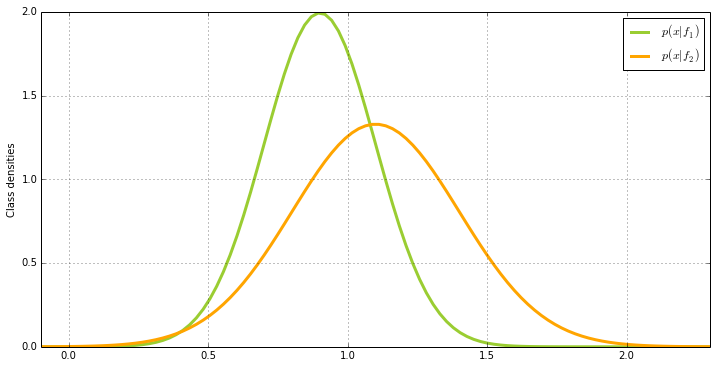

In [67]:
norm_f1 = NormalDistribution(mu=0.9, sigma=0.2)
norm_f2 = NormalDistribution(mu=1.1, sigma=0.3)

p_f1 = 0.4
p_f2 = 0.6

x_min = np.min([norm_f1.mu-4*norm_f1.sigma, norm_f2.mu-4*norm_f2.sigma])
x_max = np.max([norm_f1.mu+4*norm_f1.sigma, norm_f2.mu+4*norm_f2.sigma])

x_lin = np.linspace(x_min, x_max, 100)

p_x_g_f1 = norm_f1.pdf(x_lin)
p_x_g_f2 = norm_f2.pdf(x_lin)

plt.plot(x_lin, p_x_g_f1, color='yellowgreen', label='$p(x|f_1)$', linewidth=3)
plt.plot(x_lin, p_x_g_f2, color='orange', label='$p(x|f_2)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

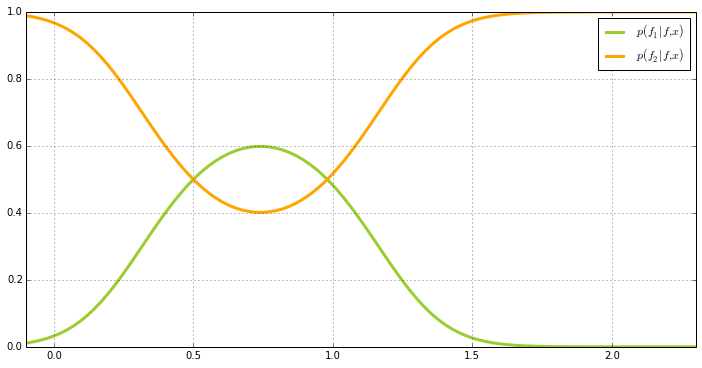

In [68]:
p_x = p_x_g_f1*p_f1 + p_x_g_f2*p_f2

p_f1_g_f_x = (p_x_g_f1*p_f1)/p_x
p_f2_g_f_x = (p_x_g_f2*p_f2)/p_x

plt.plot(x_lin, p_f1_g_f_x, color='yellowgreen', label='$p(f_1|f, x)$', linewidth=3)
plt.plot(x_lin, p_f2_g_f_x, color='orange', label='$p(f_2|f, x)$', linewidth=3)
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

### Obtaining the (k+1)-class posterior probabilities

It is possible to obtain the (k+1)-class posterior probabilities only with the class posterior probabilities within the foreground and a familiarity ratio defined as:

$$r(x) = \frac{p(f|x)}{p(b|x)}$$

From it we can get the posterior probability of the _background_

$$p(b|x) = \frac{1}{1/p(b|x)} = \frac{1}{(p(b|x)+p(f|x))/p(b|x)} = \frac{1}{1+r(x)}$$

Similarly it is possible to compute the k-class posterior probabilities

$$p(f_c|x) = p(f_c, f|x) = p(f_c|f,x)\frac{p(f|x)}{p(b|x)}p(b|x) = \frac{p(f_c|f,x)r(x)}{1+r(x)}$$

### E.g. constant familiarity ratio

As an example, imagine that we assume that the _foreground_ and the _background_ densities are the same trhough all the input space but with a different ratio. Here there is an example with different ratio values.

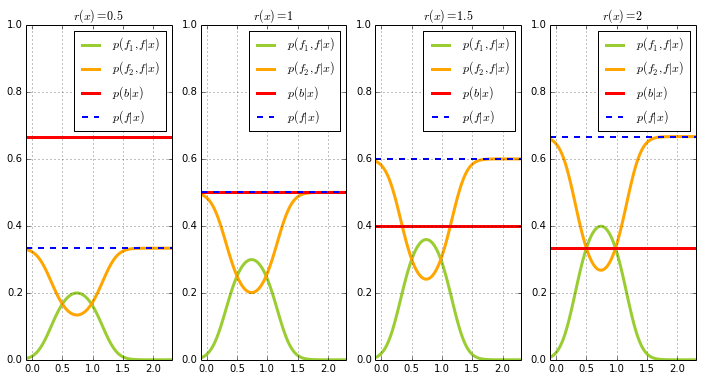

In [69]:
rs = [0.5, 1, 1.5, 2]

for i, r in enumerate(rs):
    plt.subplot(1,len(rs),i+1)
    p_b_g_x = np.ones_like(x_lin)/(1+r)

    p_f1_g_x = p_f1_g_f_x*r/(1+r)
    p_f2_g_x = p_f2_g_f_x*r/(1+r)

    plt.plot(x_lin, p_f1_g_x, color='yellowgreen', label='$p(f_1,f| x)$', linewidth=3)
    plt.plot(x_lin, p_f2_g_x, color='orange', label='$p(f_2,f| x)$', linewidth=3)
    plt.plot(x_lin, p_b_g_x, color='red', label='$p(b|x)$', linewidth=3)
    plt.plot(x_lin, p_f1_g_x+p_f2_g_x, '--', color='blue', label='$p(f|x)$', linewidth=2)
    plt.legend()
    plt.xlim([x_min, x_max])
    plt.ylim([0,1])
    plt.grid(True)
    plt.title("$r(x) = {}$".format(r))

### E.g. non-constant familiarity ratio

Another example could be if we assume that the _background_ class comes from a Normal distribution with more variance than the _foreground_. In this case the _foreground_ posterior probability will be higher on its mean, while it will be lower in farther regions.

$$ r(x) = \frac{p(f|x)}{p(b|x)} = \frac{p(f,x)p(x)}{p(b,x)p(x)} = \frac{p(f,x)}{p(b,x)}$$

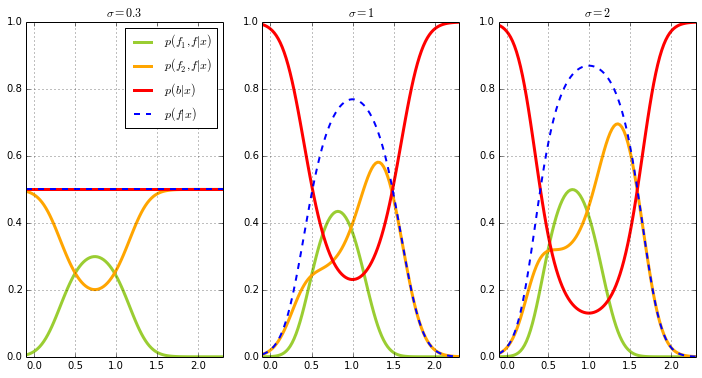

In [70]:
norm_f = NormalDistribution(mu=1, sigma=0.3)
p_f_x = norm_f.pdf(x_lin)

sigmas = [0.3,1,2]

for i, sigma in enumerate(sigmas):
    norm_b = NormalDistribution(mu=1, sigma=sigma)

    p_b_x = norm_b.pdf(x_lin)

    r = p_f_x/p_b_x
    
    plt.subplot(1,len(sigmas),i+1)
    p_b_g_x = np.ones_like(x_lin)/(1+r)

    p_f1_g_x = p_f1_g_f_x*r/(1+r)
    p_f2_g_x = p_f2_g_f_x*r/(1+r)

    plt.plot(x_lin, p_f1_g_x, color='yellowgreen', label='$p(f_1,f| x)$', linewidth=3)
    plt.plot(x_lin, p_f2_g_x, color='orange', label='$p(f_2,f| x)$', linewidth=3)
    plt.plot(x_lin, p_b_g_x, color='red', label='$p(b|x)$', linewidth=3)
    plt.plot(x_lin, p_f1_g_x+p_f2_g_x, '--', color='blue', label='$p(f|x)$', linewidth=2)
    plt.xlim([x_min, x_max])
    plt.ylim([0,1])
    plt.grid(True)
    plt.title("$\sigma = {}$".format(sigma))
    if i==0:
        plt.legend()

## Familiarity ratio

Because we are only interested in the ratio between the _foreground_ and the _background_ classes we can define a relative density $q_f(x)$ for the _foreground_ and $q_b(x)$ for the _background_ as follows:

$$
q_f(x) = \frac{p(x,f)}{\max_x p(x,f)}, \\
q_b(x) = \frac{p(x,b)}{\max_x p(x,f)}
$$

Then we can use these two functions instead of the real densities to compute the familiarity ratio

$$r(x)=\frac{p(x,f)}{p(x,b)} = \frac{q_f(x) \max_x p(x,f)}{q_b(x) \max_x p(x,f)} = \frac{q_f(x)}{q_b(x)}$$

Furthermore, it is possible to estimate the relative _foreground_ density estimation from the likelihood $p(x|f)$ and in the other way around as:

$$
q_f(x) = \frac{p(x|f)}{\max_xp(x|f)}, \\
p(x|f) = \frac{q_f(x)}{\int_x q_f(x) \,dx}
$$

## Estimating the Relative _Foreground_/_Background_ Densities

For that reason, we will need to infer the density of the background given the only information available from the _foreground_. In the absense of knowledge we will argue four different _inductive biases_ each one stronger than the previous one.

### Inductive bias 1

The _background_ density has any function $\mu$ with rescpect the _foreground_

$$q_b(x) = \mu(q_f(x))$$    

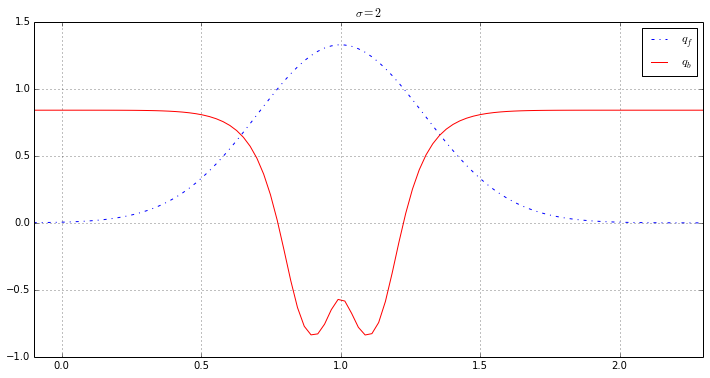

In [93]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_b = np.sin(np.cos(np.tan(q_f)))

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\sigma = {}$".format(sigma))
plt.legend()

### Inductive bias 2

The _backgrond_ denstiy is monotonically increasing or decreasing with respect to the _foreground_

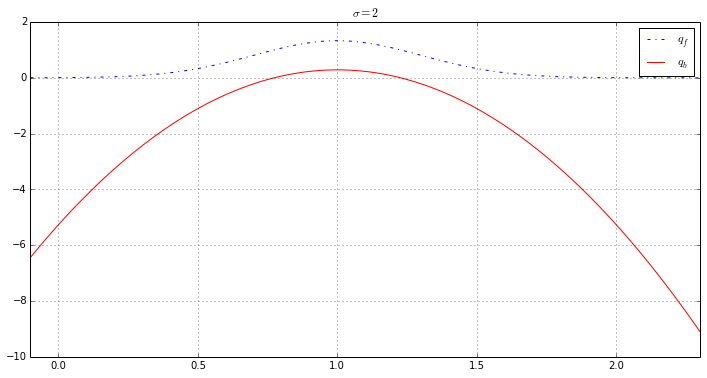

In [105]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_b = np.log(q_f)

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\sigma = {}$".format(sigma))
plt.legend()

### Inductive bias 3

The _backgrond_ denstiy is monotonically incresing or decreasing within fixed bounds $\mu(0)$ and $\mu(1)$.

$$ q_b(x) = (1-q_f(x))\mu(0) + q_f(x)\mu(1)$$

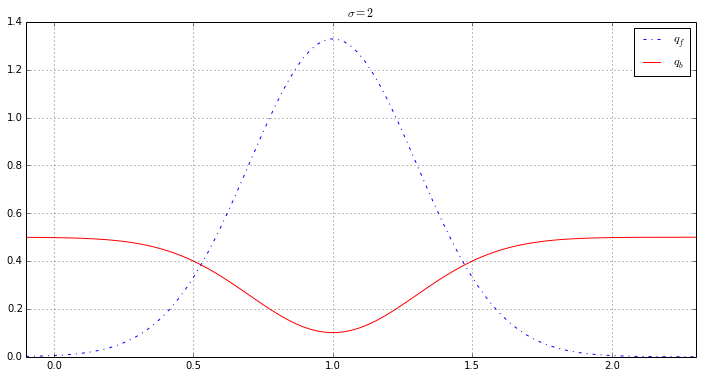

In [107]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_b = (1-q_f)*0.5 + q_f*0.2

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\sigma = {}$".format(sigma))
plt.legend()

### Inductive bias 4

The _background_ density is constant in all the feature space. This is a particualr case in which $\mu(0) = \mu(1) = 0.5$

$$ q_b(x) = (1-q_f(x))0.5 + q_f(x)0.5 = 0.5 $$

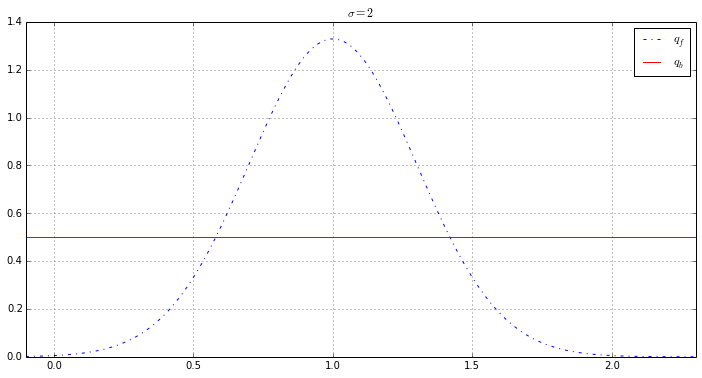

In [108]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_b = (1-q_f)*0.5 + q_f*0.5

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\sigma = {}$".format(sigma))
plt.legend()

# Binary classification example

Imagine a simple classification example between lemons and oranges where the only feature is the relative size to a tennis ball.

We can define the next notation for the different fruits and sizes:

- $Y_l$: Lemon
- $Y_o$: Orange

Then, we can colect some lemons and oranges and try to estimate what are the different probabilities. In order to get these examples all the fruits that are not lemons or oranges are discarded as we do not need to classify between other fruits. Then we get a cleaned sample containing only the desired lemons and orange with their respective relative size to a tennis ball.

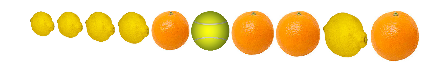

In [71]:
size_of_tennis_ball = 1
y = np.array(['lemon', 'lemon', 'lemon', 'lemon', 'orange', 'orange', 'orange', 'lemon', 'orange'])
x  = np.array([0.66, 0.7, 0.8, 0.85, 0.98, 1.1, 1.15, 1.2, 1.25])

draw_in_row(fruits, sizes)

# Priors

Lets assume that the prior probabilities for lemons and oranges are the proportions
of these fruits in our sample.

In [72]:
p_l = len(x[fruits == 'lemon'])/len(x)
p_o = len(x[fruits == 'orange'])/len(x)

print('P(Y_l) = {}'.format(p_l))
print('P(Y_o) = {}'.format(p_o))

P(Y_l) = 0.555555555556
P(Y_o) = 0.444444444444


## Density estimation

Lets make the assumption that the sizes of the different fruits are normally distributed with a mean and variance determined by the previous sample.

Thus we get the parameters $\mu$ and $\sigma^2$ by applying maximum likelihood

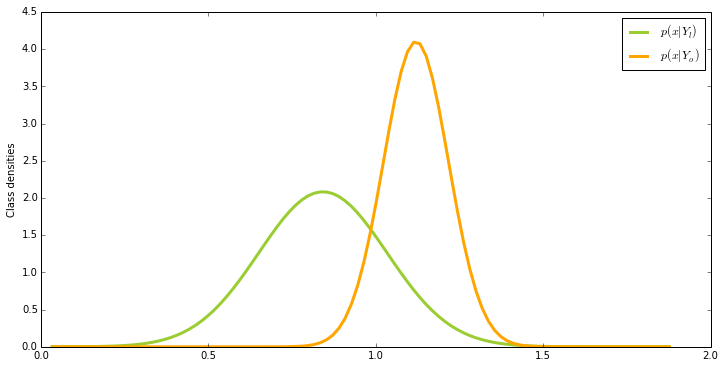

In [73]:
norm_l = NormalDistribution(x[y == 'lemon'])
norm_o = NormalDistribution(x[y == 'orange'])

x_lin = np.linspace(x.min()-3*x.std(), x.max()+3*x.std(), 100)

p_x_g_l = norm_l.pdf(x_lin)
p_x_g_o = norm_o.pdf(x_lin)

plt.plot(sizes_lin, p_x_g_l, color='yellowgreen', label='$p(x|Y_l)$', linewidth=3)
plt.plot(sizes_lin, p_x_g_o, color='orange', label='$p(x|Y_o)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()

# Posterior probabilities (Bayes' rule)

What are the posterior probabilities of each fruit given its relative size $s$

$$
    P(Y_l|x) = \frac{P(x|Y_l)*P(Y_l)}{P(x)}
$$

where

$$
    p(x) = \sum_k p(x|Y_k)p(Y_k)
$$

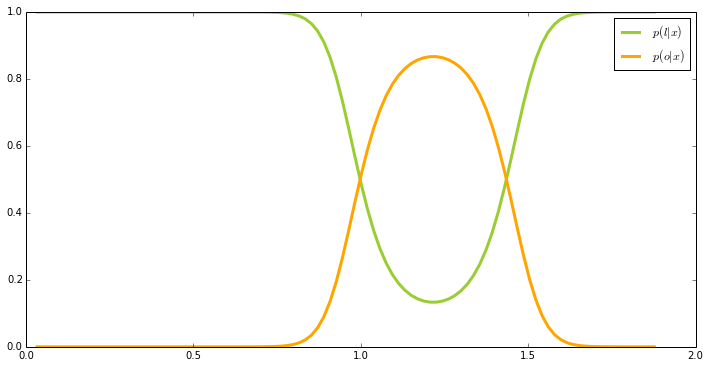

In [74]:
p_x = p_x_g_l*p_l + p_x_g_o*p_o

p_l_g_x = (p_x_g_l*p_l)/p_x
p_o_g_x = (p_x_g_o*p_o)/p_x

plt.plot(x_lin, p_l_g_x, color='yellowgreen', label='$p(l|x)$', linewidth=3)
plt.plot(x_lin, p_o_g_x, color='orange', label='$p(o|x)$', linewidth=3)
plt.legend()

### Discussion

To compute the posterior probabilities we divided the probabilities $p(x,Y_l)$ and $p(x,Y_o)$ to their sum. This is making the assumption that these two classes are all of the possible classes.

### Definition 1

For any instance x we define its familiarity factor $r(x)$ as follows:

$$
r(x) = \frac{p(f|x)}{p(b|x)}
$$

### Proposition 1

$$
p(b|x) = \frac{1}{1 + r(x)}, \\
p(f_c|x) = \frac{p(f_c|f,x)r(x)}{1+r(x)} \text{for} c = 1,\dots,k
$$

Now that we have this information we can try to estimate what is the probability of getting a lemon or an orange given a specific size.

Bayes theorem states that:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|\bar L)*P(\bar L)}
$$

However, because it is not possible to estimate $P(S)$ for all the possible objects, it is assumed that we can get an estimate in our given sample with lemons and apples. In our case, we are assuming that all the objects that are not lemons are apples. Then Bayes' theorem can be written as:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A)}
$$

Where $P(A)$ is the probability of being an apple and $P(S|A)$ is the probability of being small given that it is an apple.

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A) + P(S|\bar A, \bar L)*P(\bar A,\bar L)}
$$

## Deployment time

However, during deployment time there is nobody that can asure that the fruits that are being predicted are only lemons and oranges. It is possible that the factory got some other fruits in the collecting time.

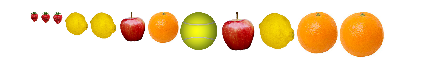

In [6]:
fruits = np.array(['strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'apple', 'orange',
                   'orange', 'apple', 'lemon', 'orange', 'orange'])
sizes  = np.array([.3, .33, .36, .7, .8, .85, .9, 1.1, 1.1, 1.1, 1.2, 1.3])

draw_in_row(fruits, sizes)

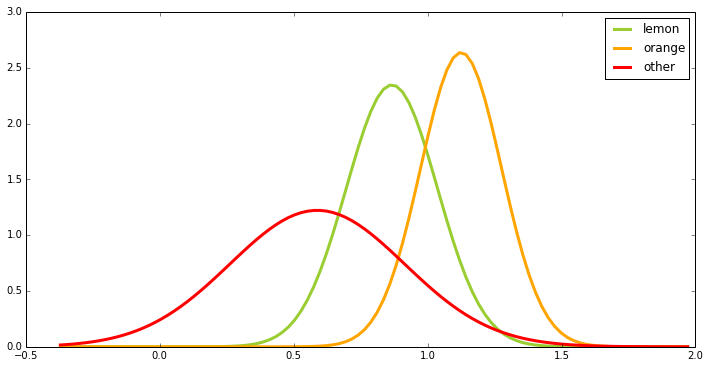

In [8]:
estimator_lemons = MyMultivariateNormal()
estimator_lemons.fit(sizes[fruits == 'lemon'])
estimator_oranges = MyGMM(n_components=1)
estimator_oranges.fit(np.array(sizes[fruits == 'orange']).reshape(-1,1))
estimator_background = MyMultivariateNormal()
estimator_background.fit(sizes[np.logical_and(fruits != 'lemon', fruits != 'orange')])

sizes_linspace = np.linspace(sizes.min()-2*sizes.std(), sizes.max()+2*sizes.std(), 100).reshape(-1,1)

P_R_g_L = estimator_lemons.score(sizes_linspace)
P_R_g_O = estimator_oranges.score(sizes_linspace)
P_R_g_nL_nO = estimator_background.score(sizes_linspace)

plt.plot(sizes_linspace, P_R_g_L, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_nL_nO, color='red', label='other', linewidth=3)
plt.legend()

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R|\bar O, \bar L)*P(\bar O,\bar L)}
$$

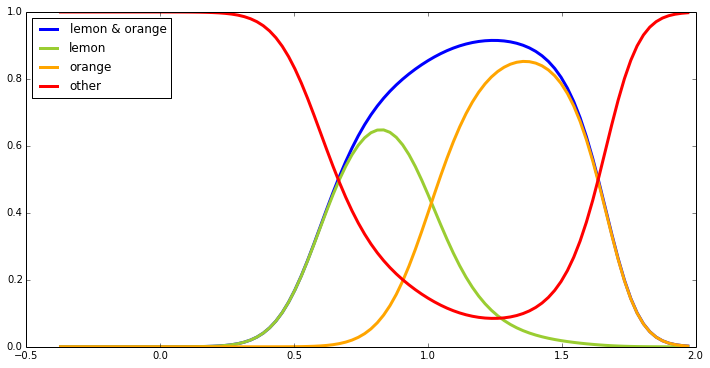

In [9]:
P_L = np.mean(fruits == 'lemon')
P_O = np.mean(fruits == 'orange')
P_nL_nO = P_L = np.mean(np.logical_and(fruits != 'lemon', fruits != 'orange'))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_R_g_nL_nO*P_nL_nO

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R
P_nL_nO_g_R = P_R_g_nL_nO*P_nL_nO/P_R

plt.plot(sizes_linspace, P_L_g_R+P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.legend(loc='upper left')

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R,B)}
$$

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


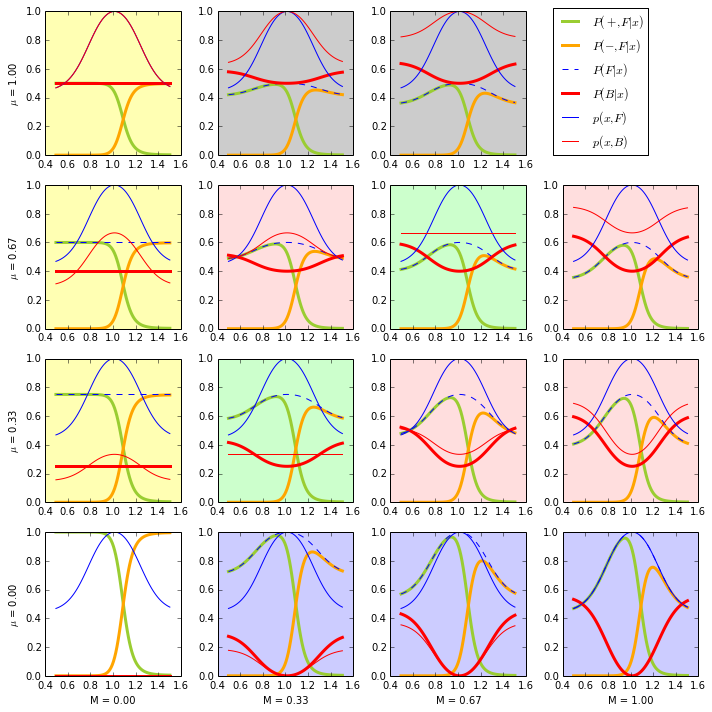

In [10]:
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.autolayout'] = True

x = sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1)
sizes_linspace = np.linspace(x.min()-x.std(), x.max()+x.std(), 100).reshape(-1,1)

n_values = 4
values = np.linspace(0,1,n_values)

paint_background = True
fig = plt.figure(figsize=(10,10))
plt.subplot(n_values, n_values, 1)
for i, mu in enumerate(reversed(values)):
    for j, m in enumerate(values):
        estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
        estimator_foreground.fit(x)
        q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)
        
        P_R = P_R_g_L*P_L + P_R_g_O*P_O

        P_L_g_R = P_R_g_L*P_L/P_R
        P_O_g_R = P_R_g_O*P_O/P_R
        
        P_B_g_R = p_x_and_b/(q+p_x_and_b)
        P_F_g_R = q/(q+p_x_and_b)
        
        P_L_F_g_R = P_L_g_R*P_F_g_R
        P_O_F_g_R = P_O_g_R*P_F_g_R
        
        if i == 0 and j == (n_values-1):
            ax = plt.legend(bbox_to_anchor=(1.2, 0), loc='lower left', borderaxespad=0.)
        else:
            ax = plt.subplot(n_values, n_values, i*n_values+j+1)
            ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
            ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

            ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
            ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
            ax.set_ylim([0,1])
        
        if i == n_values-1:
            ax.set_xlabel('M = {:.2f}'.format(m))
        if j == 0:
            ax.set_ylabel('$\mu$ = {:.2f}'.format(mu))
        
        if paint_background:
            if i == n_values-1:
                ax.set_axis_bgcolor((.8,.8,1))

            if j == 0:
                ax.set_axis_bgcolor((1,1,.7))

            if i == (n_values-1) and j == 0:
                ax.set_axis_bgcolor((1,1,1))
            elif (i != (n_values-1) and j != 0) and not (i == 0 and j == (n_values-1)):
                if (n_values-i-1) == j:
                    ax.set_axis_bgcolor((0.8,1,0.8))
                elif i == 0:
                    ax.set_axis_bgcolor((.8,.8,.8))
                else:
                    ax.set_axis_bgcolor((1,.87,.87))

            
fig.savefig('check_your_background_fig_1.pdf')

In [11]:
est_1 = BackgroundCheck(mu=mu, m=m)
est_2 = BackgroundCheck(estimator=MultivariateNormal(), mu=mu, m=m)
est_3 = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
est_4 = BackgroundCheck(estimator=MyGMM(), mu=mu, m=m)

est_1.fit(x)
est_2.fit(x)
est_3.fit(x)
est_4.fit(x)

print("\nMaximum score")
print est_1.score(x).max()
print est_2.score(x).max()
print est_3.score(x).max()
print est_4.score(x).max()

print("\nMaximum estimator score")
print est_1._estimator.score(x).max()
print est_2._estimator.score(x).max()
print est_3._estimator.score(x).max()
print est_4._estimator.score(x).max()

print("\nMaximum dens")
print est_1._max_dens
print est_2._max_dens
print est_3._max_dens
print est_4._max_dens


Maximum score
0.576440366445
1.79735106288
1.79735106288
1.77969209045

Maximum estimator score
0.576440366445
1.79735106288
1.79735106288
1.77969209045

Maximum dens
0.746994883246
0.769301704114
0.797684540573
0.764392706776


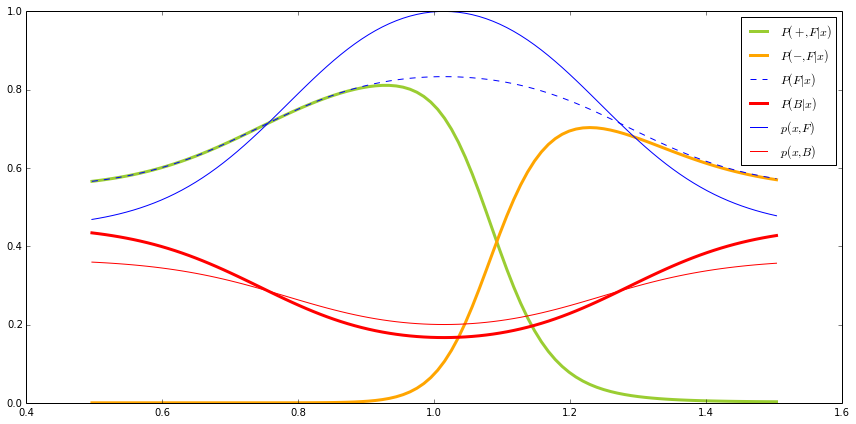

In [12]:
estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=0.2, m=0.5)
estimator_foreground.fit(x)
q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)

P_R = P_R_g_L*P_L + P_R_g_O*P_O

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R

P_B_g_R = p_x_and_b/(q+p_x_and_b)
P_F_g_R = q/(q+p_x_and_b)

P_L_F_g_R = P_L_g_R*P_F_g_R
P_O_F_g_R = P_O_g_R*P_F_g_R



plt.figure()
ax = plt.subplot(111)
ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
ax.set_ylim([0,1])
ax.legend()

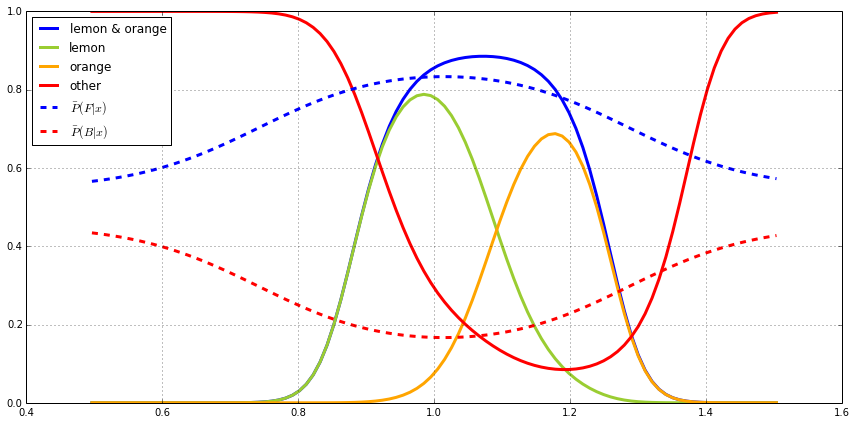

In [13]:
estimator_foreground = BackgroundCheck(mu=0.9, m=0.5)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_B_g_R

plt.plot(sizes_linspace, (P_R_g_L*P_L + P_R_g_O*P_O)/P_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_L*P_L/P_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O*P_O/P_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, P_F_g_R, '--', color='blue', label=r'$\barP(F|x)$', linewidth=3)
plt.plot(sizes_linspace, P_B_g_R, '--', color='red', label=r'$\barP(B|x)$', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)

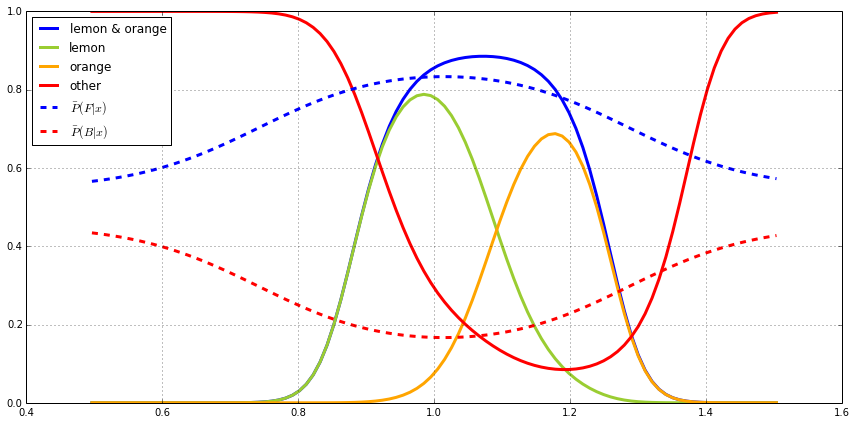

In [14]:
estimator_foreground = BackgroundCheck(mu=0.2, m=0.8)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_B_g_R

plt.plot(sizes_linspace, (P_R_g_L*P_L + P_R_g_O*P_O)/P_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_L*P_L/P_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O*P_O/P_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, P_F_g_R, '--', color='blue', label=r'$\barP(F|x)$', linewidth=3)
plt.plot(sizes_linspace, P_B_g_R, '--', color='red', label=r'$\barP(B|x)$', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)


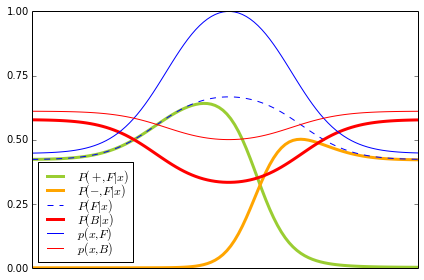

In [15]:
mu=0.5
m=0.7

plt.rcParams['figure.autolayout'] = True

x = sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1)
sizes_linspace = np.linspace(x.min()-2*x.std(), x.max()+2*x.std(), 100).reshape(-1,1)

fig = plt.figure(figsize=(6,4))

estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
estimator_foreground.fit(x)
q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)

P_R = P_R_g_L*P_L + P_R_g_O*P_O

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R

P_B_g_R = p_x_and_b/(q+p_x_and_b)
P_F_g_R = q/(q+p_x_and_b)

P_L_F_g_R = P_L_g_R*P_F_g_R
P_O_F_g_R = P_O_g_R*P_F_g_R

ax = plt.subplot(111)
ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
ax.set_ylim([0,1])
ax.set_xlim([sizes_linspace.min(), sizes_linspace.max()])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax.legend(loc='lower left', labelspacing=-0.3)